In [ ]:
''' Creation: 2021.09.26
    Last update: 2021.10.01
    
    Electroluminecence greateyes raw images reading and plotting 
    
    '''

# Standard library import
import os.path
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np

#Internal import 
import PVcharacterization_Utils as pv

file_names = ["SERAPHIM-EM-0640_Isc_ap500hXDH.dat",
              "JINERGY3272023326035_Isc_T2.dat",
              "JINERGY3272023326035_Isc_T1.dat",
              "EL_Komma_Problem.dat"
              ]

file_name = file_names[1]

file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_name)

borne_sup = np.Inf
borne_inf = 800
filter_image = False

electrolum = pv.read_electolum_file(file,pack=True)

if len(electrolum.image) > 1:
    fig = plt.figure(figsize=(16,12))
    gs = fig.add_gridspec(7,2, hspace=0.5, wspace=0)
    axe = gs.subplots(sharex='col')
    for index, image in enumerate(electrolum.image):
        #if index == 6 : break
        
        if filter_image : image = np.where((image < borne_inf) | ( image > borne_sup), 0, image)
            

        axe[index,0].imshow(image,
                   cmap='gray', 
                   interpolation=None)
        for axis in ['top','bottom','left','right']:
            axe[index,0].spines[axis].set_linewidth(0)
        
        image_flatten = image.flatten()
        if filter_image :image_flatten = image_flatten[image_flatten != 0]
        _ = axe[index,1].hist(image_flatten, bins='auto')
        axe[index,1].set_ylim([0,50000])
        
        file_gsf = os.path.splitext(file_name)[0] + '_' + str(index+1) + '.gsf'
        file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
        pv.py2gwyddion(image, file)
        

else: # Full image treatment
    fig,axe = plt.subplots(1,2,figsize=(10,5))
    for index, image in enumerate(electrolum.image):
        if filter_image : image = np.where((image < borne_inf) | ( image > borne_sup), 0, image)
        axe[0].imshow(image,
                   cmap='gray', 
                   interpolation=None)
        for axis in ['top','bottom','left','right']:
            axe[0].spines[axis].set_linewidth(2)
            
        image_flatten = image.flatten()
        if filter_image : image_flatten = image_flatten[image_flatten != 0]
        
        _ = axe[1].hist(image.flatten(), bins='auto')
        axe[1].set_ylim([0,7*50000])
    
        file_gsf = os.path.splitext(file_name)[0] + '.gsf'
        file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
        pv.py2gwyddion(image, file)
plt.show()

In [ ]:
from skimage.transform import hough_transform

image = electrolum.image[2]

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

h, theta, d = hough_transform.hough_line(image)
fig = plt.figure()
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')


In [ ]:
from skimage.transform.hough_transform import hough_line, hough_line_peaks
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Construct test image

image = np.zeros((100, 100))


# Classic straight-line Hough transform

idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

h, theta, d = hough_line(image)

plt.figure(figsize=(8, 4))

plt.subplot(131)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')


In [ ]:
''' Creation: 2021.09.26
    Last update: 2021.10.04
    
    Electroluminecence greateyes raw images reading, croping and plotting 
    
    '''

# Standard library import
import os
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv


NCOLS_SUPPRESS = 10 # Number of columns supressed for the image plotting

# Reads, crops and stitches the set of electroluminesence images acquired with greateyes camera
file_names = ["SERAPHIM-EM-0640_Isc_ap500hXDH.dat",
              "JINERGY3272023326035_Isc_T2.dat",
              "JINERGY3272023326035_Isc_T1.dat",
              "EL_Komma_Problem.dat"
              ]
file_name = file_names[3]

file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_name)

croped_image = pv.crop_image(file)

# Plots the image throwing away the NCOLS_SUPPRESS first columns
fig,axe = plt.subplots(1,1,figsize=(15,15))
axe.imshow(croped_image[:,NCOLS_SUPPRESS:],
           cmap='gray', 
           interpolation=None)
for axis in ['top','bottom','left','right']:
            axe.spines[axis].set_linewidth(0)
axe.set_xticklabels([])
axe.set_yticklabels([])
axe.set_xticks([])
axe.set_yticks([])
plt.title(file_name)

# Dumps the image in Gwyddion Simple Field Files format
file_gsf = os.path.splitext(file_name)[0] + '_full.gsf'
file = pv.GLOBAL['WORKING_DIR_EL'] / Path(file_gsf)
pv.py2gwyddion(croped_image, file) 

In [ ]:
from skimage.transform import hough_transform

image = croped_image

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

h, theta, d = hough_transform.hough_line(image)
fig = plt.figure()
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

fig = plt.figure()
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature


# Generate noisy image of a square
image = np.zeros((128, 128), dtype=float)
image[32:-32, 32:-32] = 1

image = ndi.rotate(image, 15, mode='constant')
image = ndi.gaussian_filter(image, 4)
image = random_noise(image, mode='speckle', mean=100)

image = croped_image

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=100)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 23 10:18:47 2022

@author: GR270188

This is a script to deal with EL images, it can plot all the images with the same scale
and also do auto cropping of the images if option is activated
put all raw tif 16 bit images in the same folder and select it throught the pop up window
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
import tkinter
from tkinter.filedialog import askopenfilename, askdirectory
import datetime
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import PVcharacterization_Utils as pv
# option ######################################################################
option_scale = []#[min,max] or [] specify scale limits i.e. [0,35000]
option_color = 'plasma'#'plasma','viridis','gray','inferno','turbo', etc.. type matplotlib.cm.get_cmap('abcd') in the console for full list
option_autocrop = "y"# "y" / "n"
autocrop_para = {'2D SG window_size':7,
                 '2D SG order':4,
                 'laplacian kernel size':7,
                 'laplacian kernel sigma':4,
                 'fraction of the std laplacian':5,
                 'ind_h_min':25,
                 'ind_h_max':1980}
#dirbase = 'H:/Python Scripts/EL'
dirbase = 'S:/370-Energie/370.67-Projets_INES/370.67.546-21-00708_TRIDENT/60-Document Travail/60.3-Etudes'

# data and res folder #########################################################
rooot = tkinter.Tk()
rooot.geometry('+200+200')
rooot.attributes("-topmost", True)
rooot.withdraw()
rooot.lift()

data_folder = askdirectory(parent=rooot, title="Folder of all images",initialdir=dirbase)
pres=os.path.splitext(data_folder)[0]+'/EL '+datetime.datetime.now().strftime("%y-%m-%d %Hh%M")
os.mkdir(pres)

# open images #################################################################
file_fig = [f for f in glob.glob(data_folder+'/' + "**.tif", recursive=False)]
list_fig_name = [os.path.splitext(os.path.basename(f))[0] for f in file_fig]
list_im = []

print("importing images")
for i in tqdm(range(len(file_fig))):
    list_im.append(cv2.imread(file_fig[i],cv2.IMREAD_UNCHANGED))

dim_im = np.array([f.shape for f in list_im])

Cmax=0
for i in range(len(list_im)):
    list_im[i]=list_im[i][::-1,:]
    Cmax = np.amax([Cmax,list_im[i].max()])

print("saving images")
cmap = matplotlib.cm.get_cmap(option_color).copy()
cmap.set_over('green')
cmap.set_under('green')
plt.ioff()
gs = matplotlib.gridspec.GridSpec(1, 1)
if len(option_scale)==2:
    print("using "+ str(option_scale[0])+" to "+str(option_scale[1]) +" as color scale")
    c_scale = option_scale
    if option_scale[1]<Cmax:
        print("WARNING: max color scale is "+str(option_scale[1]) +" but max data is "+str(Cmax) +" some pixels will be out of scale")
    
else:
    c_scale = [0,Cmax]

for i in tqdm(range(len(file_fig))):
    fig10 = plt.figure(10,figsize=(dim_im[i,1]/400, dim_im[i,0]/400))
    ax10 = fig10.add_subplot(gs[0, 0])
    ax10.imshow(list_im[i],cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])#
    ax10.set_axis_off()
    fig10.tight_layout(pad=0)
    fig10.savefig(pres+'/'+list_fig_name[i]+'.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
    plt.close(fig10)

fig100 = plt.figure(100,figsize=(dim_im[0,1]/400, dim_im[0,0]/400))
gs = matplotlib.gridspec.GridSpec(1, 4)
ax100 = fig100.add_subplot(gs[0, :-1])
ax100im = ax100.imshow(list_im[i],cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])
ax100.set_axis_off()
#fig100.tight_layout(pad=0)
axin100 = inset_axes(ax100,width="4%",height="100%",loc='lower left',bbox_to_anchor=(1.04, 0., 1, 1),bbox_transform=ax100.transAxes,borderpad=0,)
ccbar1 = plt.colorbar(ax100im,cax=axin100)#, format='%.5d'
#ccbar1.ax.tick_params(labelsize=tiksiz)
ccbar1.set_label('Intensity (Arb. U.)')
axin100.text(1.8*axin100.get_xlim()[1],1.05*c_scale[1]-c_scale[0],str(c_scale[1]))
axin100.text(1.8*axin100.get_xlim()[1],-0.05*c_scale[1]-c_scale[0],str(c_scale[0]), verticalalignment='top')
fig100.savefig(pres+'/'+'@scale.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
plt.close(fig100)

plt.ion()



if option_autocrop == "y":
    os.mkdir(pres+'/cropped')
    print("auto cropping images")
    plt.ioff()
    gs = matplotlib.gridspec.GridSpec(1, 1)
    for i in tqdm(range(len(file_fig))):
        array_im_red = pv.ines_crop(list_im[i],autocrop_para)
        fig11 = plt.figure(11,figsize=(array_im_red.shape[1]/400, array_im_red.shape[0]/400))
        ax11 = fig11.add_subplot(gs[0, 0])
        ax11.imshow(array_im_red,cmap=cmap,vmin=c_scale[0],vmax=c_scale[1])
        ax11.set_axis_off()
        fig11.tight_layout(pad=0)
        fig11.savefig(pres+'/cropped'+'/'+list_fig_name[i]+'.png', format='png', dpi=400)#, orientation='portrait', transparent=True, bbox_inches='tight', pad_inches=0.0,facecolor='None'
        plt.close(fig11)

print('\nResults in :\n')
print(pres)

Number of detected displays: 2


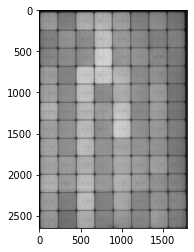

In [1]:
#Internal import 
import PVcharacterization_Utils as pv

from matplotlib import image
import cv2#pip install opencv-python
import matplotlib.pyplot as plt

autocrop_para = {'2D SG window_size':7,
                 '2D SG order':4,
                 'laplacian kernel size':7,
                 'laplacian kernel sigma':4,
                 'fraction of the std laplacian':5,
                 'ind_h_min':25,
                 'ind_h_max':1980}

# load image as pixel array
file = r'C:\Users\franc\PVcharacterization_files\EL\intensity_normalzed\Panasonic_W3AKSNH15247_600mA_6000ms.tif'
image = image.imread(file)

array_im_red = pv.ines_crop(image,autocrop_para)

plt.imshow(array_im_red,
                   cmap='gray', 
                   interpolation=None)

In [8]:
pv.py2gwyddion(array_im_red, r'c:\Temp\crop.gsf')

In [43]:
import cv2
import numpy as np

im_sg = pv.sgolay2d(np.float32(image),
                 autocrop_para['2D SG window_size'],
                 autocrop_para['2D SG order'],
                 derivative=None)

array_im_lap = cv2.filter2D(im_sg,
                            -1,
                            pv.laplacian_kern(autocrop_para['laplacian kernel size'],
                                               autocrop_para['laplacian kernel sigma']))
std_v = np.std(array_im_lap.sum(axis=1))
ind_v = np.where(np.abs(array_im_lap.sum(axis=1)) > 
                 std_v/autocrop_para['fraction of the std laplacian'])[0]

std_h = np.std(array_im_lap.sum(axis=0))
ind_h = np.where(np.abs(array_im_lap.sum(axis=0)) > 
                 std_h/autocrop_para['fraction of the std laplacian'])[0]
ind_h = ind_h[np.where((ind_h>autocrop_para['ind_h_min'])&(ind_h<autocrop_para['ind_h_max']))[0]]

array_im_red = image[ind_v.min():ind_v.max(),ind_h.min():ind_h.max()]

In [33]:
pv.py2gwyddion(array_im_lap, r'c:\Temp\crop.gsf')

In [8]:
def analyse_morphologique(img_bin, img=None):

    """find the features in the image
    
    Args:
        img_bin (2D array): binarized image to analyze
        
        img (2D array):  image before binarization
        
    Returns:
        df (dataframe): index|'x'|'long_x'| 'y'|'long_y'| 'size'|'depth' with :
                - index: feature index
                - x: gravity center x position of the feature
                - long_x: maximum feature width
                - y: gravity center y position of the feature
                - long_y: maximum feature height
                - size: pixels number of the feature 
                - depth : feature depth
        
    """

    # 3rd party import
    import numpy as np
    from scipy.ndimage.measurements import label
    import pandas as pd

    def height(i):

        """
        compute the maximum height of feature with label i
        """
        result = np.where(labeled_array == i)
        return min([img[x] for x in zip(result[0], result[1])])

    labeled_array, num_features = label(img_bin, [[0, 1, 0], [1, 1, 1], [0, 1, 0]])

    morpho = {}

    if img is None:
        for i in range(1, np.max(labeled_array) + 1):
            y, x = np.where(labeled_array == i)  # beware x and y lecture
            morpho[i] = [
                int(np.mean(x)),  # x gravity center of label i
                max(x) - min(x) + 1,  # x length of label i
                int(np.mean(y)),  # y gravity center of label i
                max(y) - min(y) + 1,  # y length of label i
                np.sum(labeled_array == i),  # area of label i in nuber of pixels
            ]
            df = pd.DataFrame.from_dict(
                morpho, orient="index", columns=["x", "long_x", "y", "long_y", "size"]
            )
    else:
        for i in range(1, np.max(labeled_array) + 1):
            y, x = np.where(labeled_array == i)
            morpho[i] = [
                int(np.mean(x)),  # x gravity center of label i
                max(x) - min(x) + 1,  # x length of label i
                int(np.mean(y)),  # y gravity center of label i
                max(y) - min(y) + 1,  # y length of label i
                np.sum(labeled_array == i),  # area of label i in nuber of pixels
                height(i),
            ]

        df = pd.DataFrame.from_dict(
            morpho,
            orient="index",
            columns=["x", "long_x", "y", "long_y", "size", "height"],
        )

    return df

def convert(data):

    # 3rd party import
    import numpy as np

    data = data / data.max()  # normalizes data in range 0 - 255
    data = 255 * data
    return data.astype(np.uint8)

def Otsu_tresholding(im, Ostu_corr=1):
    """Image thresholding using the Otsu's method
    https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4310076
    
    Args:
        im (ndarray) : image
        
        Ostu_corr (float) : division of the Otsu threshold by Otsu_corr

    Returns:
        im_bin (ndarray) : binarized image
        
    """

    # 3rd party import
    from skimage import filters
    import numpy as np

    thresh_otsu = filters.threshold_otsu(
        convert(im)
    )  # détermination du seuil optimum selon Otsu
    im_bin = np.where((convert(im) < thresh_otsu / Ostu_corr), 1, 0)
    return im_bin

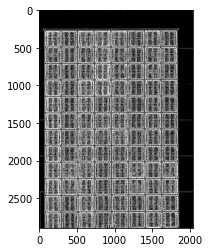

In [30]:
import cv2
import scipy
im_bin = Otsu_tresholding(array_im_lap,Ostu_corr=1)
im_bin = scipy.ndimage.median_filter(
                            im_bin,
                            size=4,
                            mode='reflect',
                           )
plt.imshow(1-im_bin,
                   cmap='gray', 
                   interpolation=None)

In [31]:
pv.py2gwyddion(1-im_bin, r'c:\Temp\crop.gsf')

In [34]:
ind_v

array([ 246,  247,  248,  250,  251,  252,  253,  255,  256,  257,  258,
        259,  260,  261,  262,  263,  264,  265,  266,  268,  269,  270,
        271,  272,  273,  274,  275,  276,  277,  278,  279,  280,  281,
        282,  283,  284,  285,  288,  292,  476,  477,  478,  479,  480,
        481,  482,  483,  484,  485,  486,  487,  488,  489,  490,  491,
        492,  493,  494,  495,  496,  497,  498,  499,  500,  501,  502,
        505,  506,  507,  694,  695,  696,  697,  698,  699,  700,  701,
        702,  703,  704,  705,  706,  707,  708,  709,  710,  711,  712,
        713,  714,  715,  716,  717,  718,  719,  720,  721,  914,  915,
        916,  917,  918,  919,  920,  921,  922,  923,  924,  925,  926,
        927,  928,  929,  930,  931,  932,  933,  934,  935,  936,  937,
        938,  939,  940,  979,  980,  981,  982,  983,  984,  985,  986,
        987,  988, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138,
       1139, 1140, 1141, 1142, 1143, 1144, 1145, 11

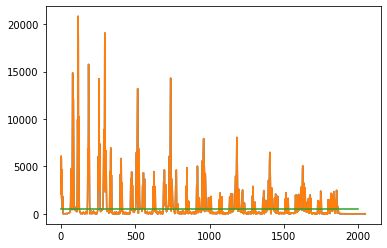

In [49]:
std_h = np.std(array_im_lap.sum(axis=0))/5
plt.plot(np.abs(array_im_lap.sum(axis=0)))

plt.plot(np.abs(array_im_lap.sum(axis=0)))
plt.plot([0,2000],[std_h,std_h])

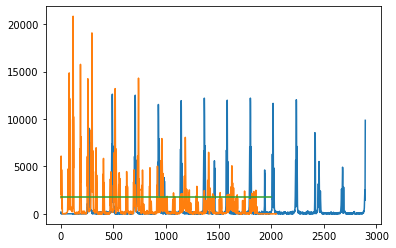

In [47]:
std_V = np.std(array_im_lap.sum(axis=1))/5
plt.plot(np.abs(array_im_lap.sum(axis=1)))

plt.plot(np.abs(array_im_lap.sum(axis=0)))
plt.plot([0,2000],[std_v,std_v])

In [42]:
np.std(array_im_lap.sum(axis=1))

1808.7004452839606